<a href="https://colab.research.google.com/github/ray0130/CAVA/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
LOG_FILES = {
    "CoA": [
        "/content/drive/MyDrive/GenAI/project/logs/hotpotqa_val_qwen3B_100samples_coa_noverif.jsonl",
        "/content/drive/MyDrive/GenAI/project/logs/hotpotqa_train_easymedium_qwen3B_coa.jsonl"
    ],
    "CAVA_every3": [
        "/content/drive/MyDrive/GenAI/project/logs/hotpotqa_val_qwen3B_every3.jsonl",
        "/content/drive/MyDrive/GenAI/project/logs/hotpotqa_train_easymedium_qwen3B_every3.jsonl"
    ],
    "CAVA_every": [
        "/content/drive/MyDrive/GenAI/project/logs/hotpotqa_val_qwen3B_every.jsonl",
        "/content/drive/MyDrive/GenAI/project/logs/hotpotqa_train_easymedium_qwen3B_every.jsonl"
    ],
    "full_context": [
        "/content/drive/MyDrive/GenAI/project/logs/hotpotqa_val_qwen3B_100samples_fullcontext_modifiedprompt_Wpostprocess.jsonl",
        "/content/drive/MyDrive/GenAI/project/logs/hotpotqa_train_easymedium_qwen3B_fullcontext_Wpostprocess_noExtractor.jsonl",
    ],
}

In [42]:
import json
import pandas as pd
from pathlib import Path

def load_jsonl_with_method(path: str, method_name: str) -> pd.DataFrame:
    rows = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            obj["method"] = method_name
            rows.append(obj)
    df = pd.DataFrame(rows)
    df = df.drop_duplicates(subset=["id", "idx", "method"]) # In case you logged duplicates
    return df

def load_all_logs(log_files: dict) -> pd.DataFrame:
    """
    log_files: dict like { "method_name": [path1, path2, ...], ... }
    Returns a single concatenated DataFrame with a 'method' column.
    """
    all_dfs = []

    for method, paths in log_files.items():
        # allow str or list[str] just in case
        if isinstance(paths, str):
            paths = [paths]

        method_dfs = []
        for p in paths:
            df = load_jsonl_with_method(p, method_name=method)
            method_dfs.append(df)

        if method_dfs:
            merged = pd.concat(method_dfs, ignore_index=True)
            # drop duplicates across files for the same method
            merged = merged.drop_duplicates(subset=["id", "idx", "method"])
            all_dfs.append(merged)

    if not all_dfs:
        return pd.DataFrame()

    all_data = pd.concat(all_dfs, ignore_index=True)
    # global de-dup just in case
    all_data = all_data.drop_duplicates(subset=["id", "idx", "method"])
    return all_data

all_df = load_all_logs(LOG_FILES)
all_df


,id,idx,type,level,question,gold_answer,prediction,f1,em,method
0,5a8b57f25542995d1e6f1371,0,comparison,hard,Were Scott Derrickson and Ed Wood of the same ...,yes,yes,1.000000,1,CoA
1,5a8c7595554299585d9e36b6,1,bridge,hard,What government position was held by the woman...,Chief of Protocol,no,0.000000,0,CoA
2,5a85ea095542994775f606a8,2,bridge,hard,"What science fantasy young adult series, told ...",Animorphs,the seer and the sword,0.000000,0,CoA
3,5adbf0a255429947ff17385a,3,comparison,hard,Are the Laleli Mosque and Esma Sultan Mansion ...,no,no\n\nnote: the reasoning process here involve...,0.250000,0,CoA
4,5a8e3ea95542995a26add48d,4,bridge,hard,"The director of the romantic comedy ""Big Stone...","Greenwich Village, New York City",no\n\nreasoning paragraph:\nthe summary only m...,0.095238,0,CoA
...,...,...,...,...,...,...,...,...,...,...
795,5ac5132255429924173fb596,95,bridge,easy,Which lead vocalist wrote songs for Black Sabb...,Ronnie James Dio,Query:\n Which lead vocalist wrote songs fo...,0.070588,0,full_context
796,5abcd62d55429965836004c8,96,bridge,medium,What is the drink sold by the convenience stor...,"""Icy Drink""",Final answer: Icy Drink\nTo determine the corr...,0.048780,0,full_context
797,5ae05bd555429924de1b70ad,97,bridge,medium,Dave Jackson was renowned for his skill on whi...,Allagash Wilderness Waterway,Based on the information provided in the sourc...,0.068182,0,full_context
798,5a8496075542997b5ce3fedc,98,bridge,easy,RapidShare was an online file hosting service ...,Megaupload Ltd,Final answer: Megaupload Ltd\n Reasoning:\n...,0.050000,0,full_context


## Quantitative

In [43]:
summary = (
    all_df.groupby("method")
    .agg(
        num_samples=("id", "nunique"),
        mean_f1=("f1", "mean"),
        mean_em=("em", "mean"),
    )
    .reset_index()
)
summary["mean_f1"] = summary["mean_f1"] * 100
summary["mean_em"] = summary["mean_em"] * 100
summary

,method,num_samples,mean_f1,mean_em
0,CAVA_every,200,20.181265,15.0
1,CAVA_every3,200,34.519147,26.5
2,CoA,200,27.202030,20.5
3,full_context,200,5.721603,1.0


In [44]:
summary_type = (
    all_df.groupby(["method", "type"])
    .agg(
        num_samples=("id", "nunique"),
        mean_f1=("f1", "mean"),
        mean_em=("em", "mean"),
    )
    .reset_index()
)
summary_type["mean_f1"] = summary_type["mean_f1"] * 100
summary_type["mean_em"] = summary_type["mean_em"] * 100
summary_type

,method,type,num_samples,mean_f1,mean_em
0,CAVA_every,bridge,159,21.145296,16.352201
1,CAVA_every,comparison,41,16.442707,9.756098
2,CAVA_every3,bridge,159,33.040518,23.899371
3,CAVA_every3,comparison,41,40.253345,36.585366
4,CoA,bridge,159,25.270040,18.238994
5,CoA,comparison,41,34.694380,29.268293
6,full_context,bridge,159,4.665256,0.000000
7,full_context,comparison,41,9.818167,4.878049


In [45]:
summary_level = (
    all_df.groupby(["method", "level"])
    .agg(
        num_samples=("id", "nunique"),
        mean_f1=("f1", "mean"),
        mean_em=("em", "mean"),
    )
    .reset_index()
)
summary_level["mean_f1"] = summary_level["mean_f1"] * 100
summary_level["mean_em"] = summary_level["mean_em"] * 100
summary_level

,method,level,num_samples,mean_f1,mean_em
0,CAVA_every,easy,50,25.784853,18.0
1,CAVA_every,hard,100,12.567494,7.0
2,CAVA_every,medium,50,29.805220,28.0
3,CAVA_every3,easy,50,45.012730,36.0
4,CAVA_every3,hard,100,22.824404,14.0
5,CAVA_every3,medium,50,47.415050,42.0
6,CoA,easy,50,34.578494,26.0
7,CoA,hard,100,18.838757,12.0
8,CoA,medium,50,36.552111,32.0
9,full_context,easy,50,4.664513,0.0


In [46]:
wide = (
    all_df
    .pivot_table(
        index=["id", "idx", "type", "level", "question", "gold_answer"],
        columns="method",
        values=["f1", "em"],
    )
)

print(wide.columns)


# make column names nicer: e.g., f1_coa, em_coa, ...
wide.columns = [f"{metric}_{method}" for metric, method in wide.columns]
wide = wide.reset_index()
wide

MultiIndex([('em',   'CAVA_every'),
            ('em',  'CAVA_every3'),
            ('em',          'CoA'),
            ('em', 'full_context'),
            ('f1',   'CAVA_every'),
            ('f1',  'CAVA_every3'),
            ('f1',          'CoA'),
            ('f1', 'full_context')],
           names=[None, 'method'])


,id,idx,type,level,question,gold_answer,em_CAVA_every,em_CAVA_every3,em_CoA,em_full_context,f1_CAVA_every,f1_CAVA_every3,f1_CoA,f1_full_context
0,5a713ea95542994082a3e6e4,77,bridge,hard,Alvaro Mexia had a diplomatic mission with whi...,Apalachees,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,5a7166395542994082a3e814,10,bridge,hard,What is the name of the fight song of the univ...,Kansas Song,0.0,0.0,0.0,0.0,0.000000,0.044444,0.000000,0.173913
2,5a722b8655429971e9dc9329,25,bridge,hard,Who was the writer of These Boots Are Made for...,Barton Lee Hazlewood,0.0,0.0,0.0,0.0,0.054054,0.000000,0.000000,0.000000
3,5a7274cb5542997f827839e1,92,comparison,easy,Which Italian European Space Agency astronaut ...,Samantha Cristoforetti,0.0,1.0,1.0,0.0,0.500000,1.000000,1.000000,0.053333
4,5a7292df5542994cef4bc347,66,bridge,medium,What subsidiary of GE Aviation build the engin...,Walter Aircraft Engines,1.0,0.0,0.0,0.0,1.000000,0.028169,0.206897,0.077922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5ae7a8175542993210983ed8,20,bridge,hard,Which other Mexican Formula One race car drive...,Pedro Rodríguez,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
196,5ae7ba7a5542993210983f12,67,bridge,hard,What is the name of the singer who's song was ...,Usher,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
197,5ae7e1fc55429952e35ea9cc,72,bridge,hard,What color clothing do people of the Netherlan...,orange,0.0,1.0,0.0,0.0,0.024096,1.000000,0.024096,0.000000
198,5ae806335542993210984040,10,bridge,medium,What year did former professional footballer w...,2013,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [47]:
from scipy.stats import ttest_rel

def paired_ttest(wide: pd.DataFrame, method_a: str, method_b: str):
    a = wide[f"f1_{method_a}"].dropna()
    b = wide[f"f1_{method_b}"].dropna()
    # align on same indices
    common = a.index.intersection(b.index)
    a = a.loc[common]
    b = b.loc[common]
    t_stat, p_val = ttest_rel(a, b)
    return t_stat, p_val

t_stat, p_val = paired_ttest(wide, "CoA", "CAVA_every")
print(f"Paired t-test CoA vs CAVA(every): tstat={t_stat}, pvalue={p_val}")

t_stat, p_val = paired_ttest(wide, "CoA", "CAVA_every3")
print(f"Paired t-test CoA vs CAVA(every3): tstat={t_stat}, pvalue={p_val}")

t_stat, p_val = paired_ttest(wide, "CAVA_every3", "CAVA_every")
print(f"Paired t-test CAVA(every3) vs CAVA(every): tstat={t_stat}, pvalue={p_val}")


t_stat, p_val = paired_ttest(wide, "full_context", "CAVA_every3")
print(f"Paired t-test full_context vs CAVA(every3): tstat={t_stat}, pvalue={p_val}")


t_stat, p_val = paired_ttest(wide, "full_context", "CAVA_every")
print(f"Paired t-test full_context vs CAVA(every): tstat={t_stat}, pvalue={p_val}")


t_stat, p_val = paired_ttest(wide, "full_context", "CoA")
print(f"Paired t-test full_context vs CoA: tstat={t_stat}, pvalue={p_val}")

Paired t-test CoA vs CAVA(every): tstat=2.1533444834051365, pvalue=0.032494524867759875
Paired t-test CoA vs CAVA(every3): tstat=-2.5018005224958872, pvalue=0.013162272176203863
Paired t-test CAVA(every3) vs CAVA(every): tstat=4.398356401589892, pvalue=1.7755510047265554e-05
Paired t-test full_context vs CAVA(every3): tstat=-9.08603466650086, pvalue=1.041105125320383e-16
Paired t-test full_context vs CAVA(every): tstat=-5.549082986608884, pvalue=9.086894243264448e-08
Paired t-test full_context vs CoA: tstat=-7.3093658862031194, pvalue=6.380354321303472e-12


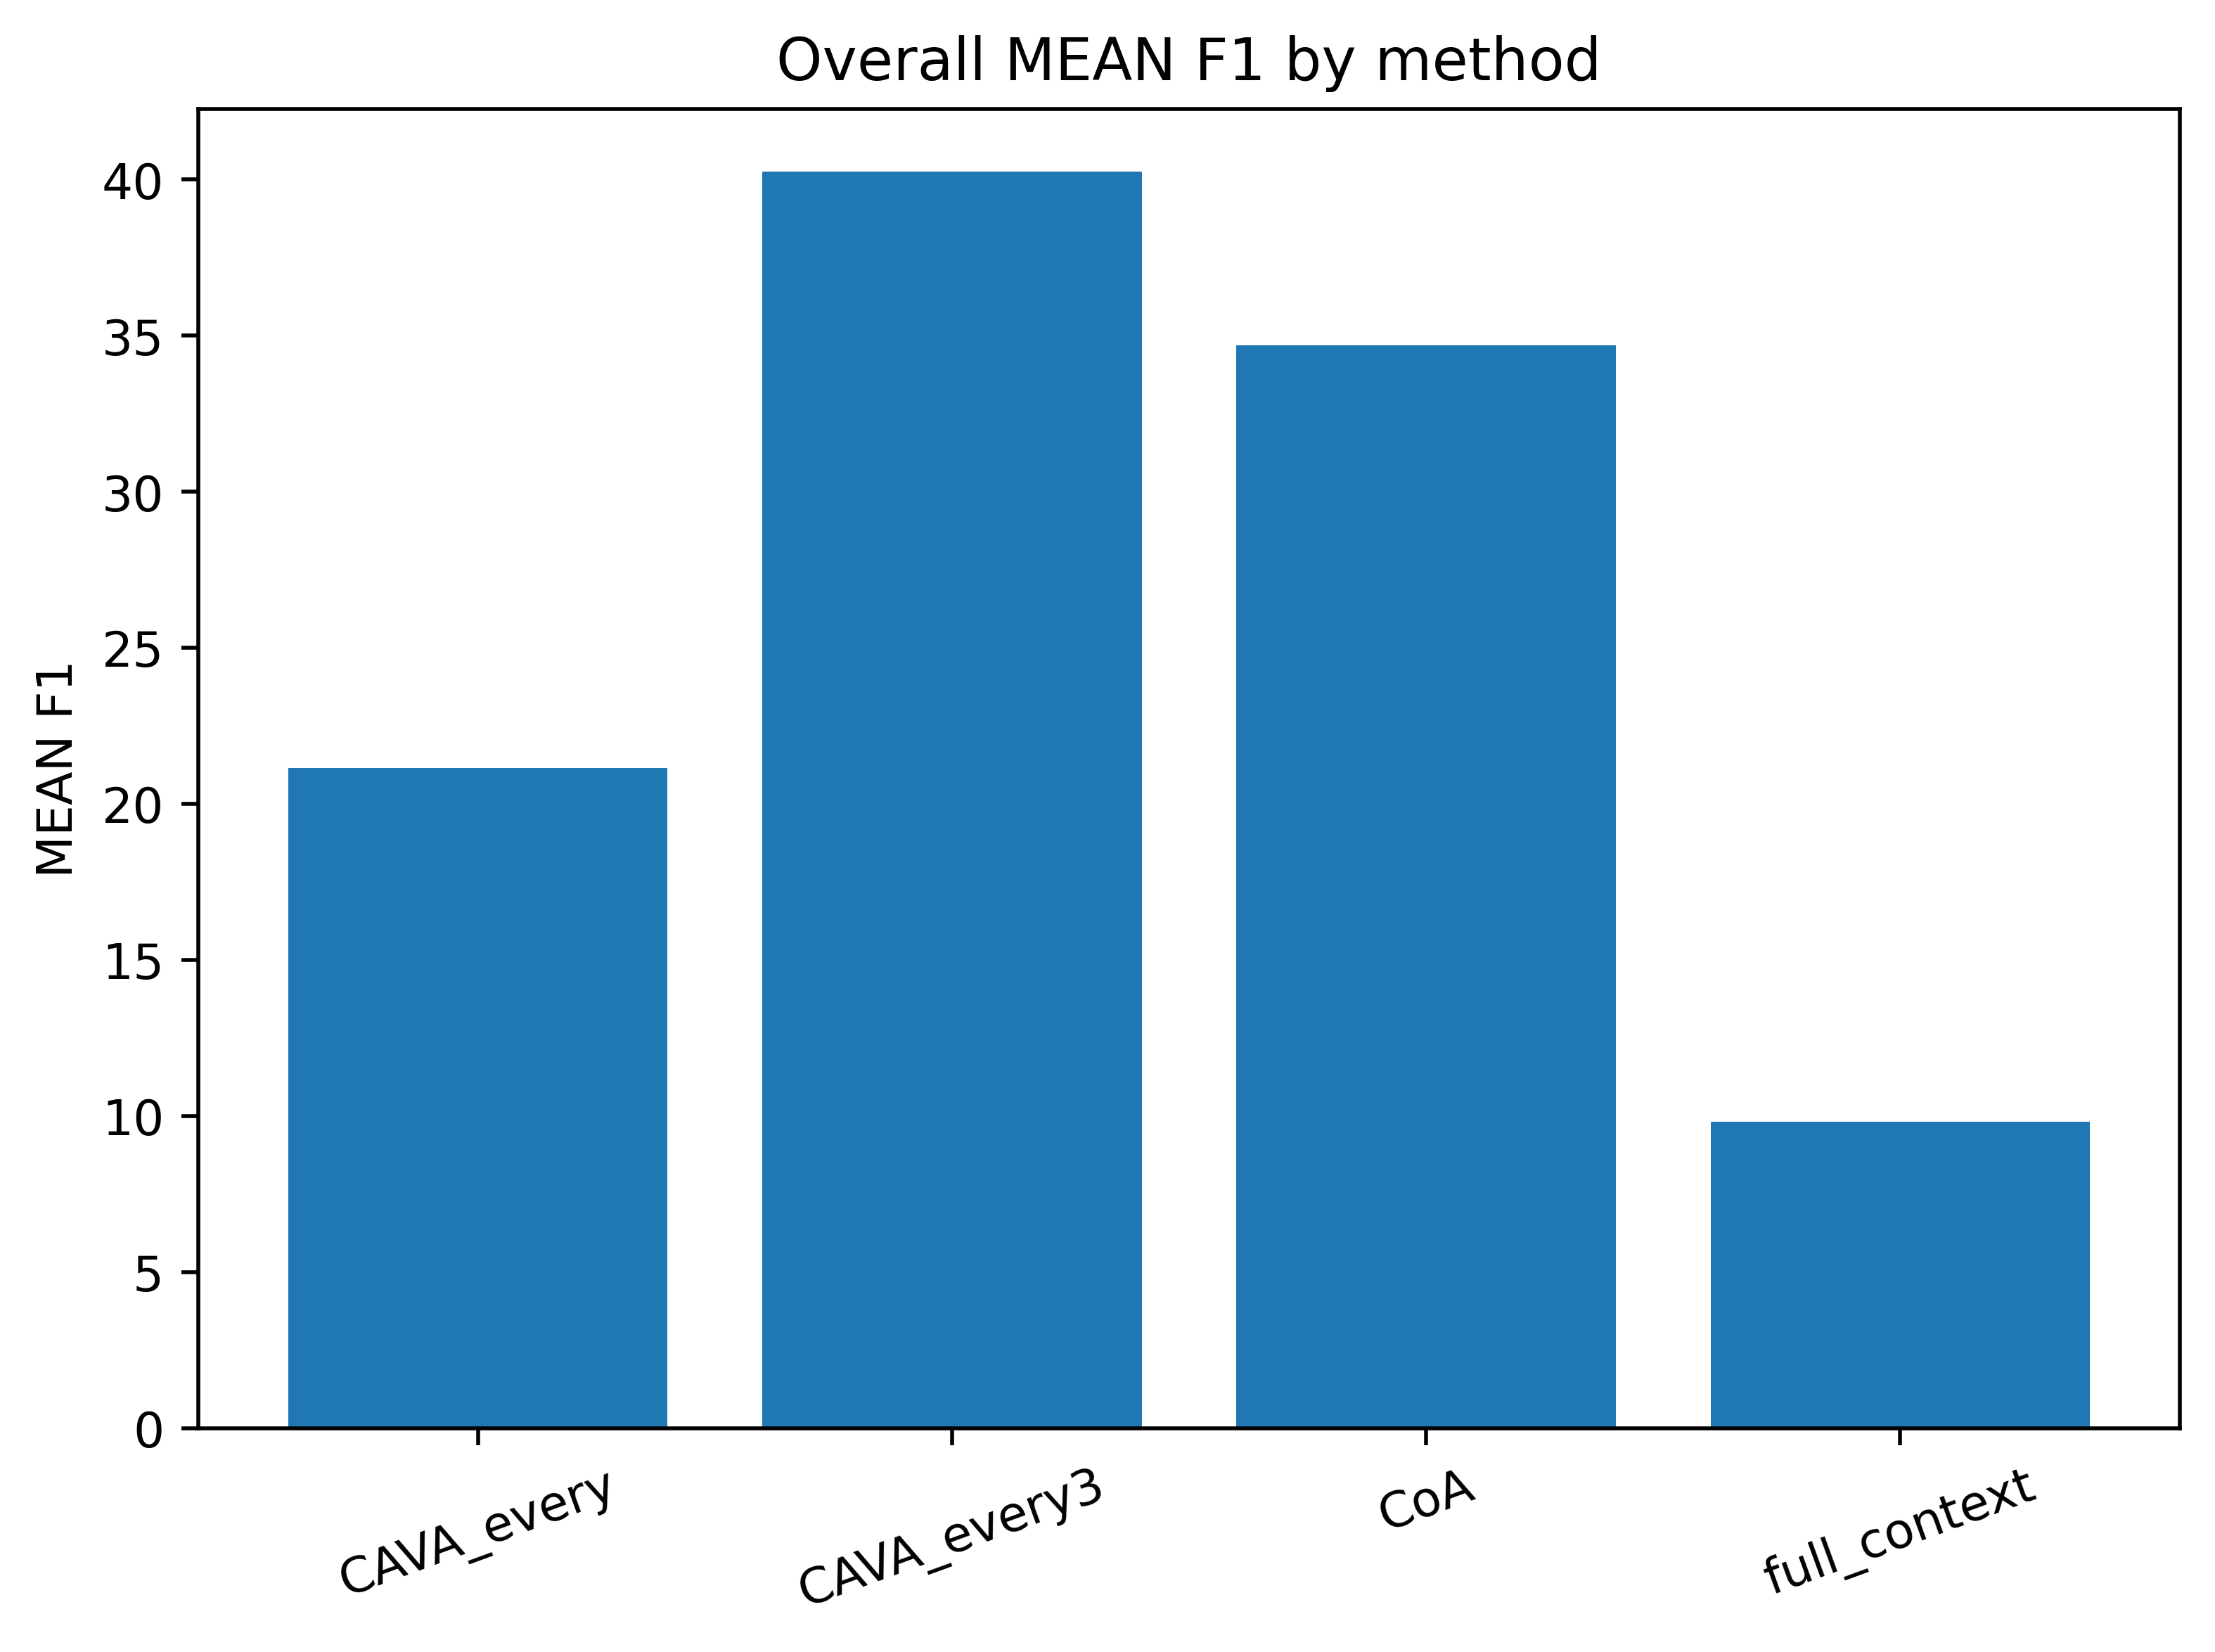

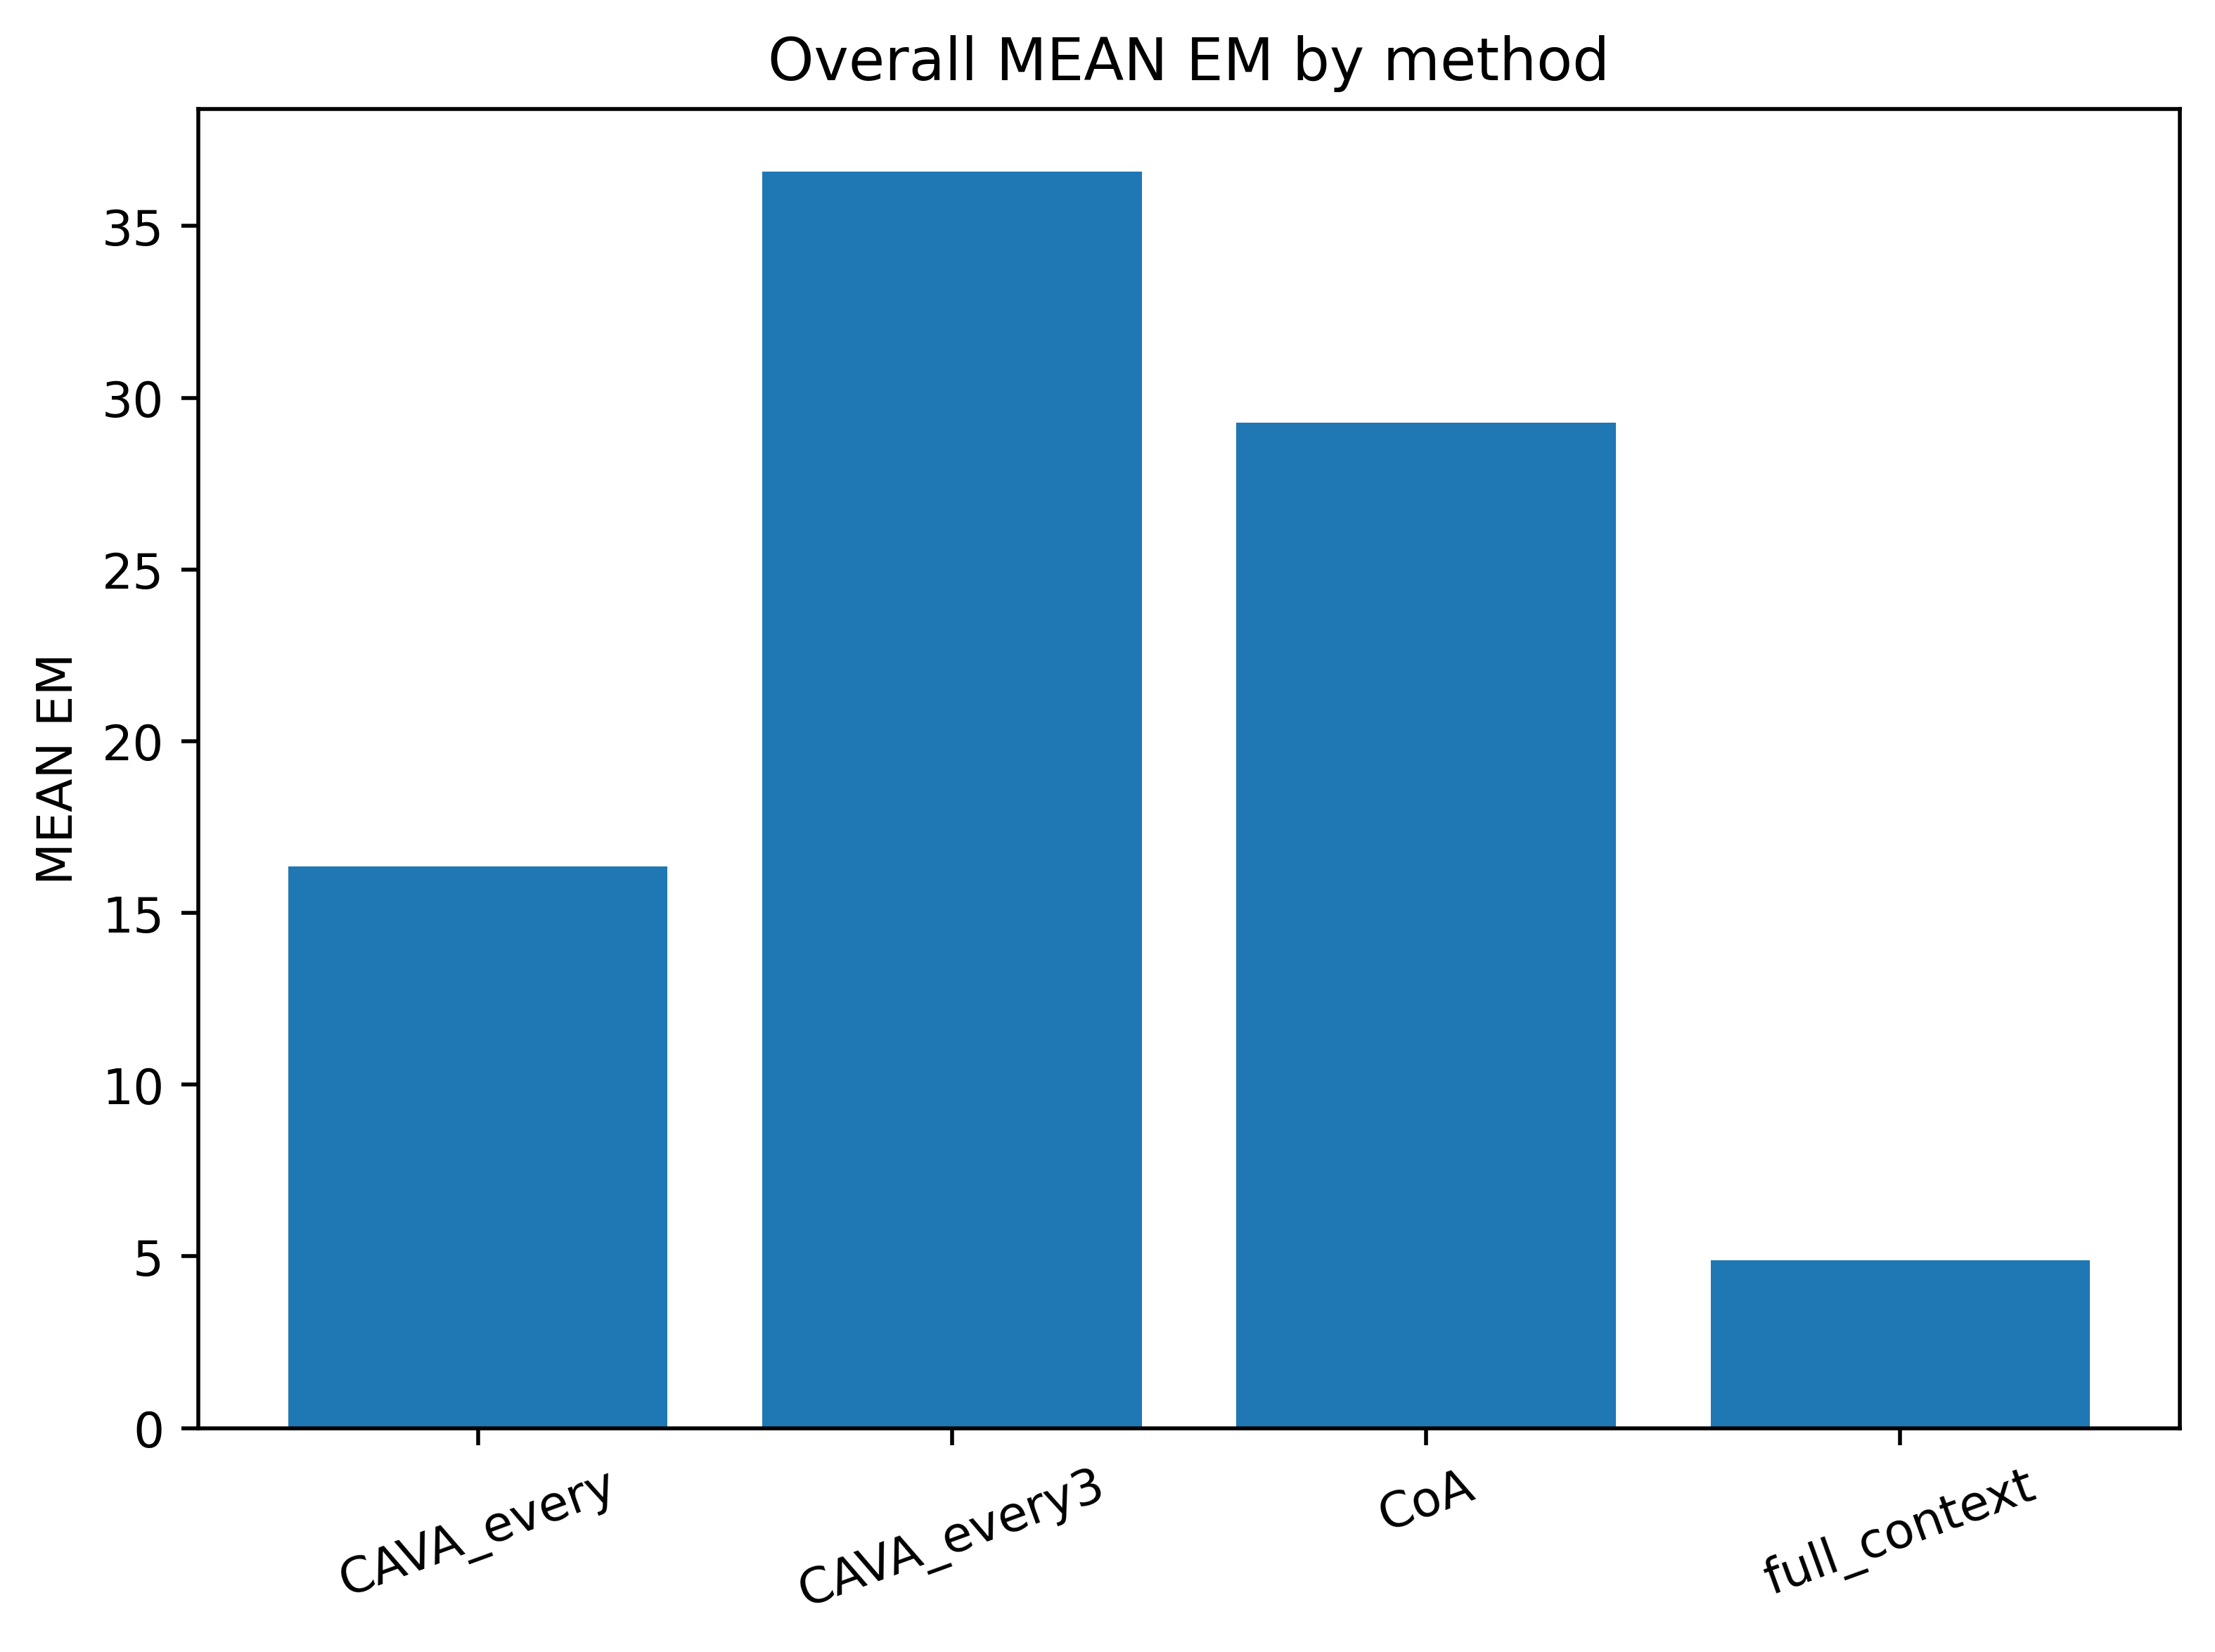

In [49]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500

def plot_overall_bar(summary: pd.DataFrame, metric: str = "mean_f1"):
    plt.figure()
    x = summary["method"]
    y = summary[metric]
    plt.bar(x, y)
    plt.ylabel(metric.replace("_", " ").upper())
    plt.xticks(rotation=20)
    plt.title(f"Overall {metric.replace('_', ' ').upper()} by method")
    plt.tight_layout()
    plt.show()

plot_overall_bar(summary_type, metric="mean_f1")
plot_overall_bar(summary_type, metric="mean_em")


/tmp/ipython-input-2992625297.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


[array([5.72160281]), array([27.2020297]), array([34.51914726]), array([20.18126543])]


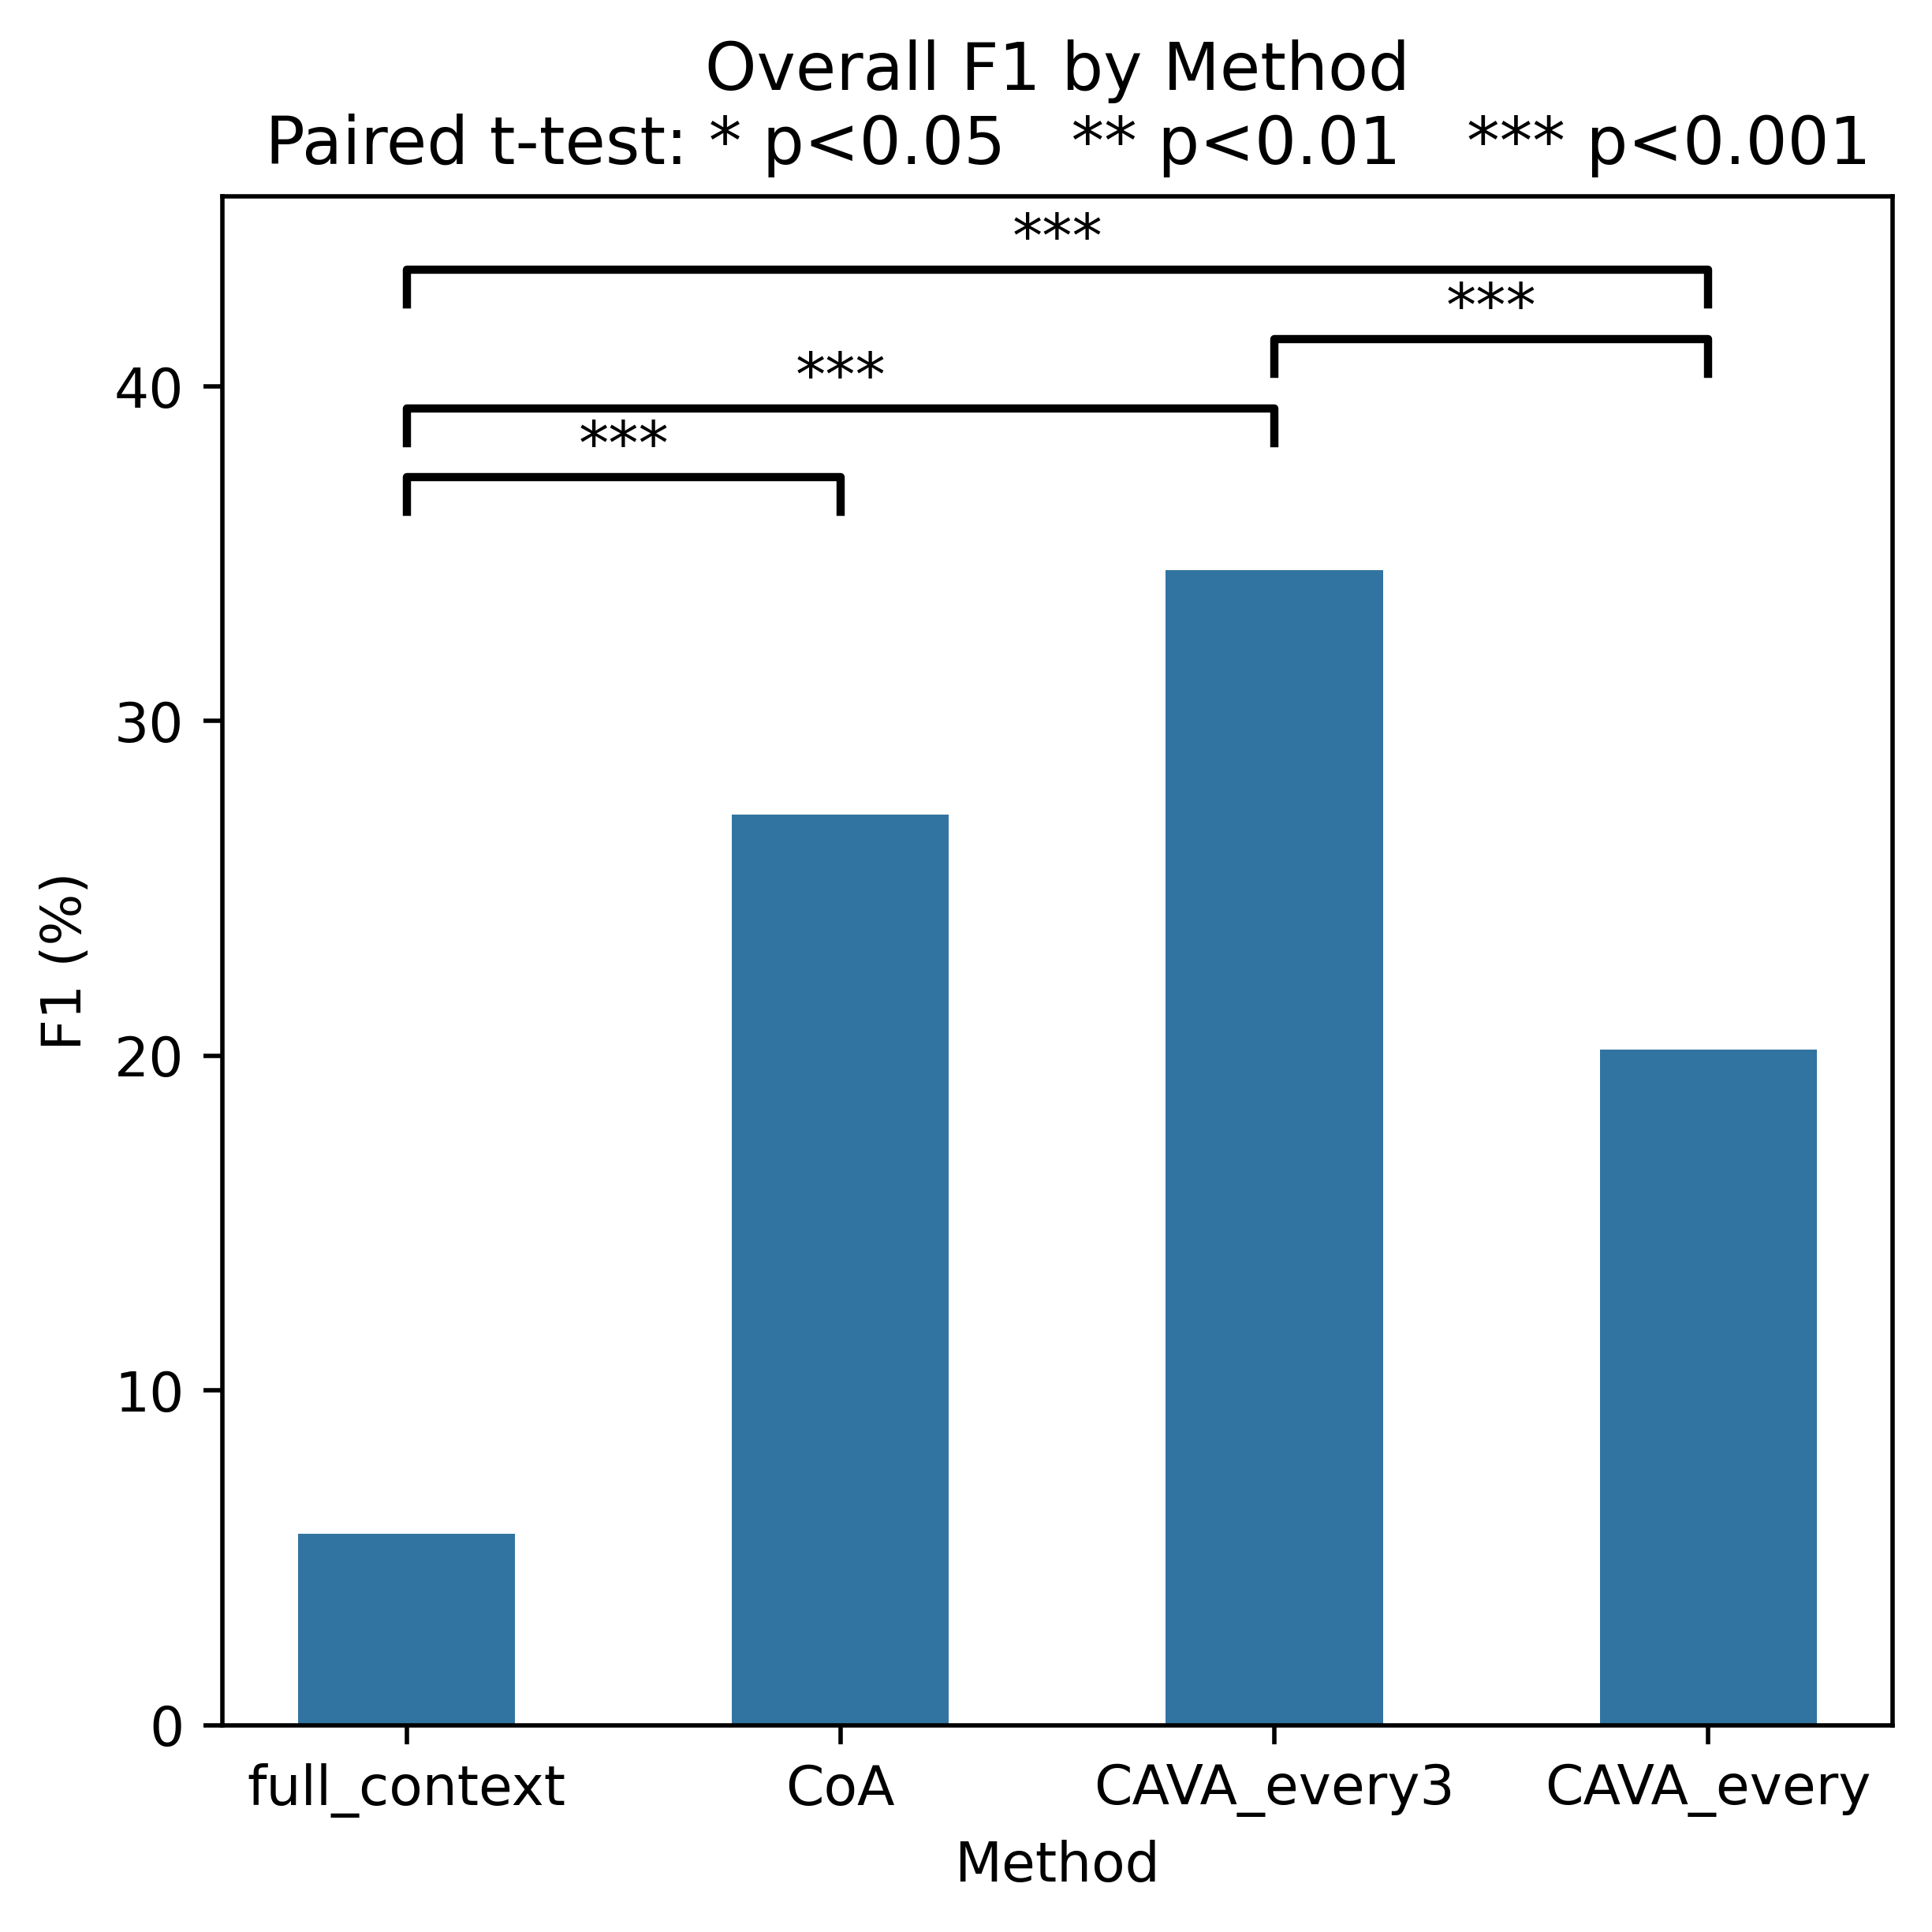

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# overall_summary DataFrame:
# columns: method, mean_f1_pct, mean_em_pct, num_samples, ...
# Make sure mean_f1_pct is already multiplied by 100 and optionally rounded

# ---- 1. Define order and subset ----
order = ["full_context", "CoA", "CAVA_every3", "CAVA_every"]
metric = "mean_f1"   # or mean_f1 "mean_em"

plot_df = summary.copy()
plot_df = plot_df[plot_df["method"].isin(order)]
plot_df["method"] = pd.Categorical(plot_df["method"], categories=order, ordered=True)

# ---- 2. Helper to map p-value -> stars ----
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "n.s."

# ---- 3. Helper to draw significance bar between two bars ----
def add_sig_bar(ax, x1, x2, y, h, text):
    """
    ax: matplotlib axes
    x1, x2: positions (indices) of the two bars
    y: baseline height to draw the bar above
    h: bar height offset
    text: annotation string (e.g. '*', '**')
    """
    # horizontal bar
    ax.plot([x1, x1, x2, x2],
            [y,  y+h, y+h, y],
            lw=1.5, c="black")
    # text in the middle
    ax.text((x1 + x2) * 0.5, y + h, text,
            ha="center", va="bottom", fontsize=11)

# ---- 4. Make bar plot ----
plt.figure(figsize=(5, 5))
sns.barplot(
    data=plot_df,
    x="method",
    y=metric,
    order=order,
    ci=None,
    width=0.5
)
plt.ylabel("F1 (%)")
plt.xlabel("Method")
plt.title("Overall F1 by Method\n Paired t-test: * p<0.05 ** p<0.01 *** p<0.001")

ax = plt.gca()

# Get bar positions and heights
xticks = np.arange(len(order))
heights = [plot_df.loc[plot_df["method"] == m, metric].values for m in order]
print(heights)

y_max = max(heights)
bar_height_offset = (y_max * 0.05)  # spacing between bars & sig lines

# Map method -> x position index
pos = {m: i for i, m in enumerate(order)}

# ---- 5. Add only significant comparisons ----
# You already computed these p-values externally via paired t-tests.
# Fill in that dict (or compute them in code and reuse).
# Paired t-test CoA vs CAVA(every): tstat=2.1533444834051365, pvalue=0.032494524867759875
# Paired t-test CoA vs CAVA(every3): tstat=-2.5018005224958872, pvalue=0.013162272176203863
# Paired t-test CAVA(every3) vs CAVA(every): tstat=4.398356401589892, pvalue=1.7755510047265554e-05
# Paired t-test full_context vs CAVA(every3): tstat=-9.08603466650086, pvalue=1.041105125320383e-16
# Paired t-test full_context vs CAVA(every): tstat=-5.549082986608884, pvalue=9.086894243264448e-08
# Paired t-test full_context vs CoA: tstat=-7.3093658862031194, pvalue=6.380354321303472e-12

pvals = {
    ("full_context", "CoA"): 6.380354321303472e-12,
    ("full_context", "CAVA_every3"): 1.041105125320383e-16,
    ("CAVA_every3", "CAVA_every"): 1.7755510047265554e-05,
    ("CoA", "CAVA_every"): 0.032494524867759875,
    ("CoA", "CAVA_every3"): 0.013162272176203863,
    ("full_context", "CAVA_every"): 9.086894243264448e-08,
}

# Which pairs to actually annotate (only p < 0.05)
pairs_to_plot = [
    ("full_context", "CoA"),
    ("full_context", "CAVA_every3"),
    ("CAVA_every3", "CAVA_every"),
    ("full_context", "CAVA_every")
]

current_y = y_max + bar_height_offset

for (m1, m2) in pairs_to_plot:
    p = pvals[(m1, m2)]
    stars = p_to_stars(p)
    if stars == "n.s.":
        continue  # skip if not significant

    x1 = pos[m1]
    x2 = pos[m2]

    add_sig_bar(ax, x1, x2, current_y, h=bar_height_offset * 0.6, text=stars)
    current_y += bar_height_offset * 1.2  # stack higher for next comparison

plt.tight_layout()
plt.show()


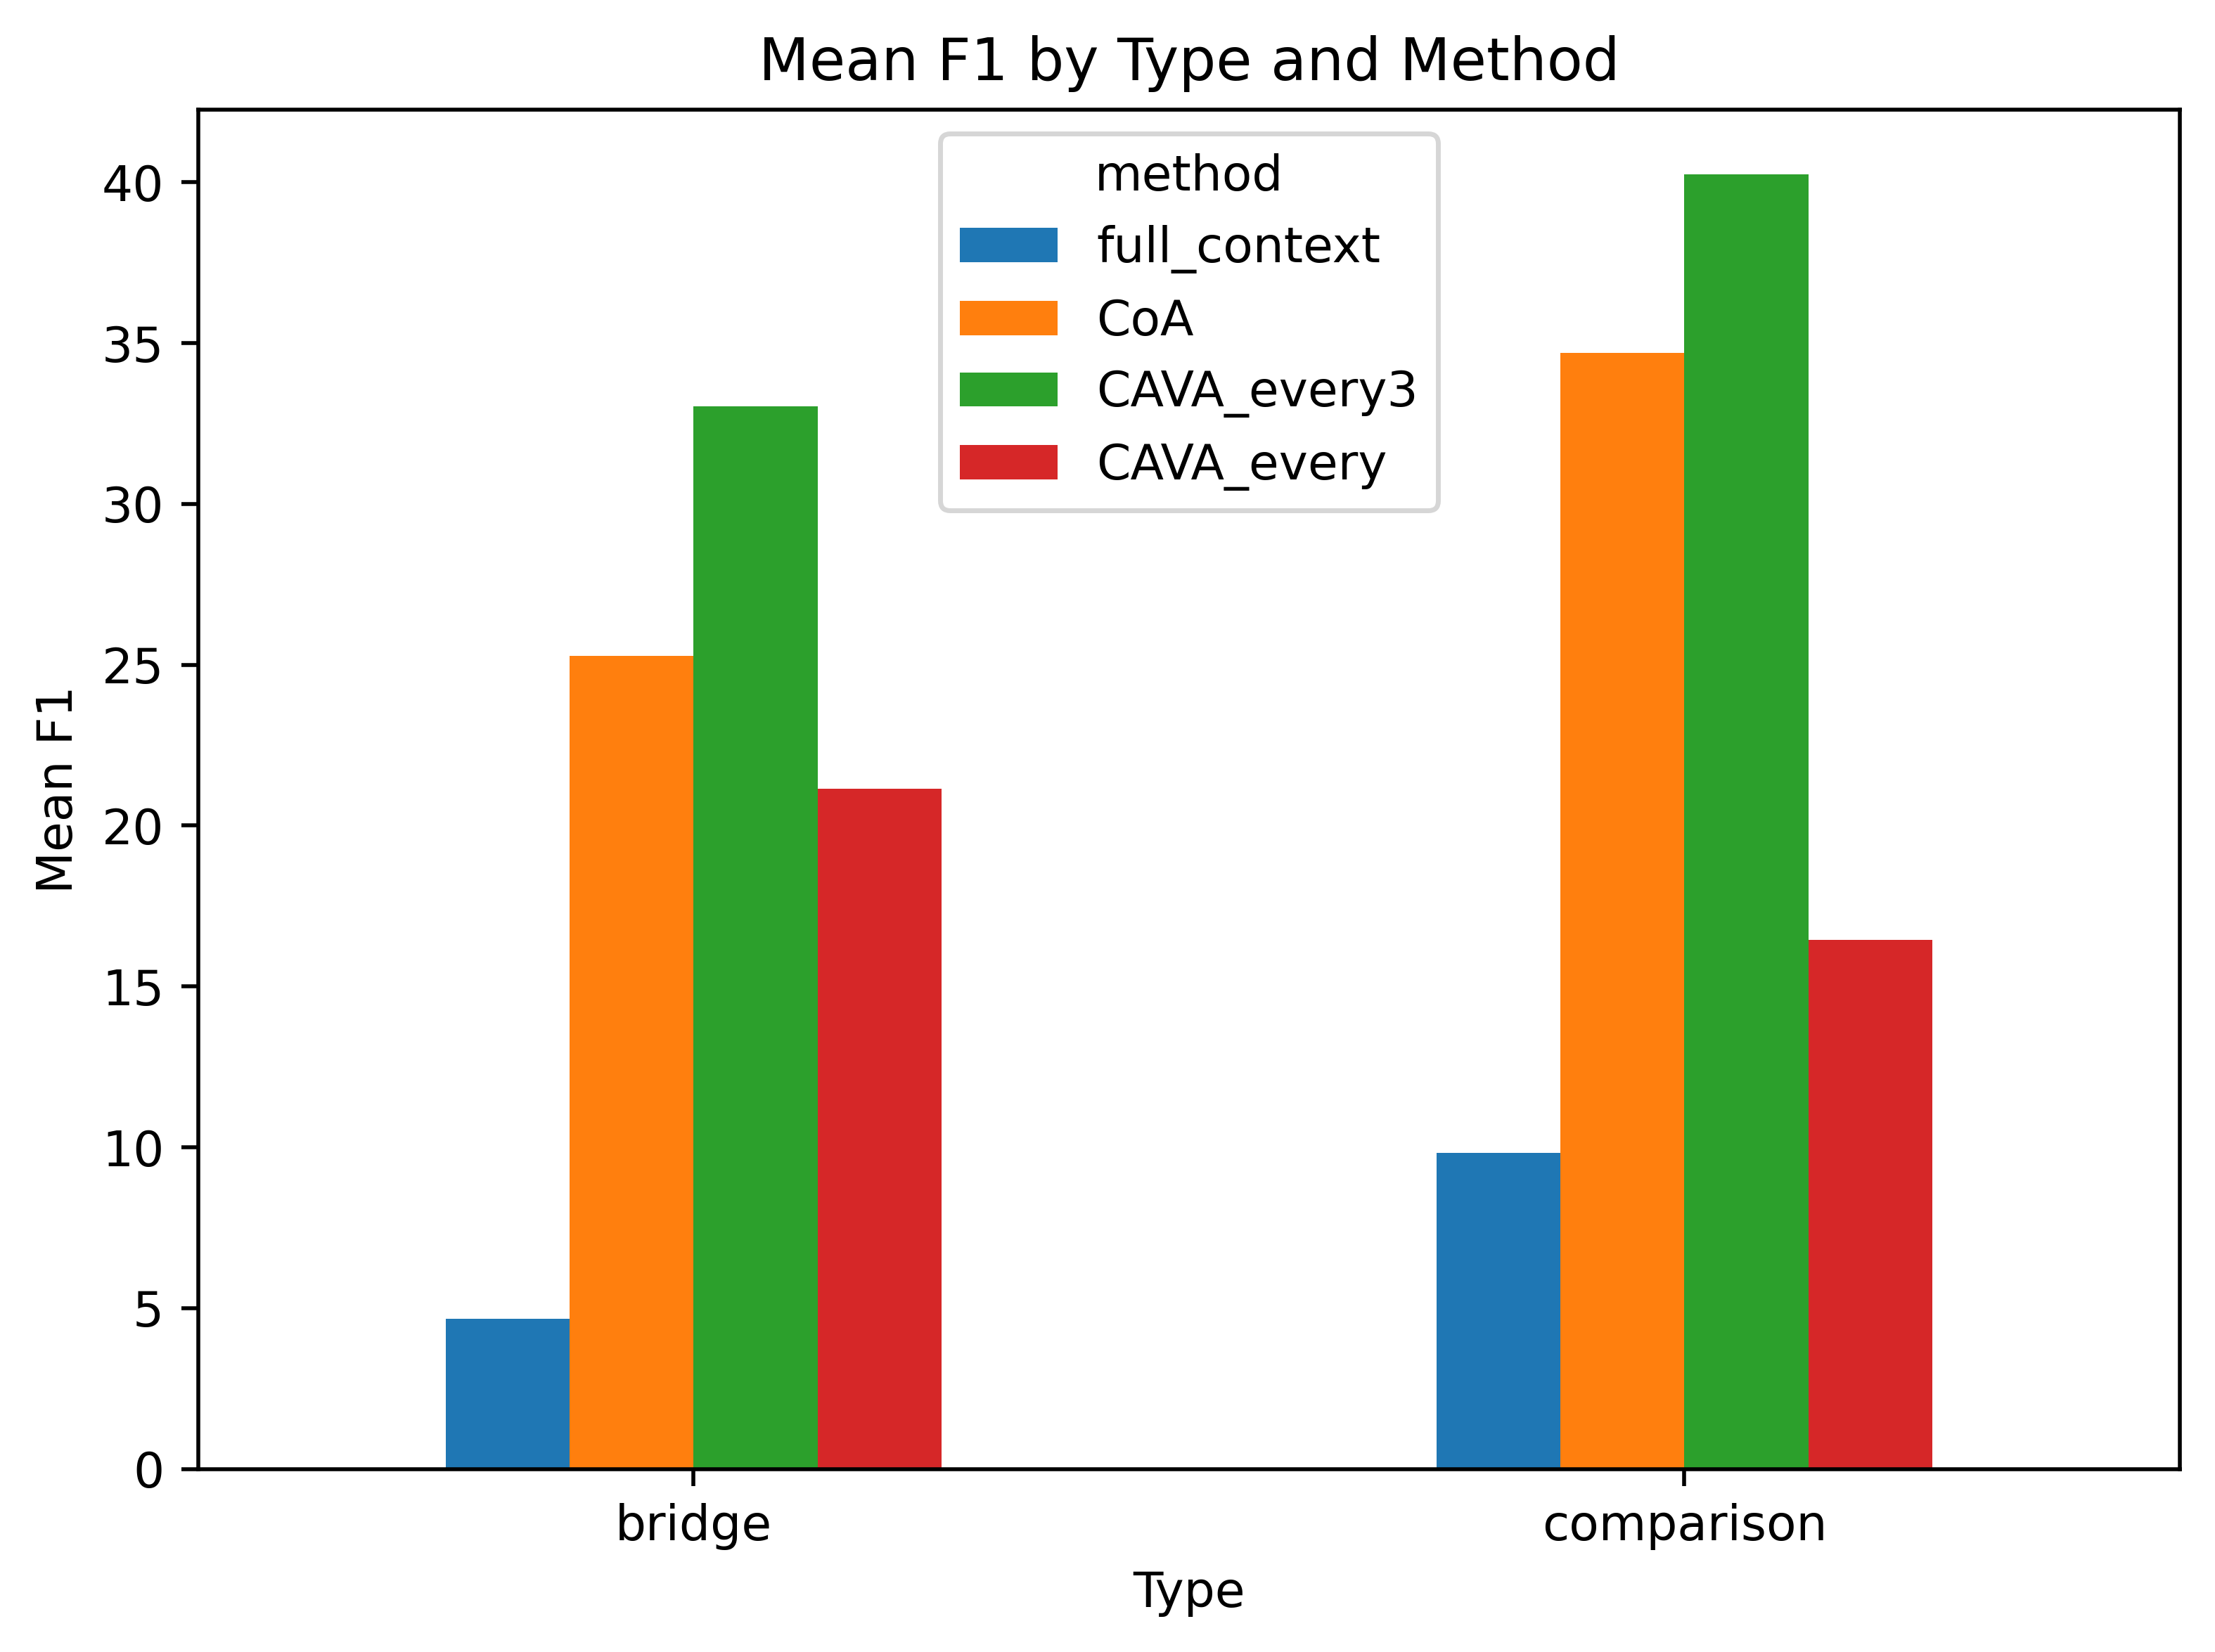

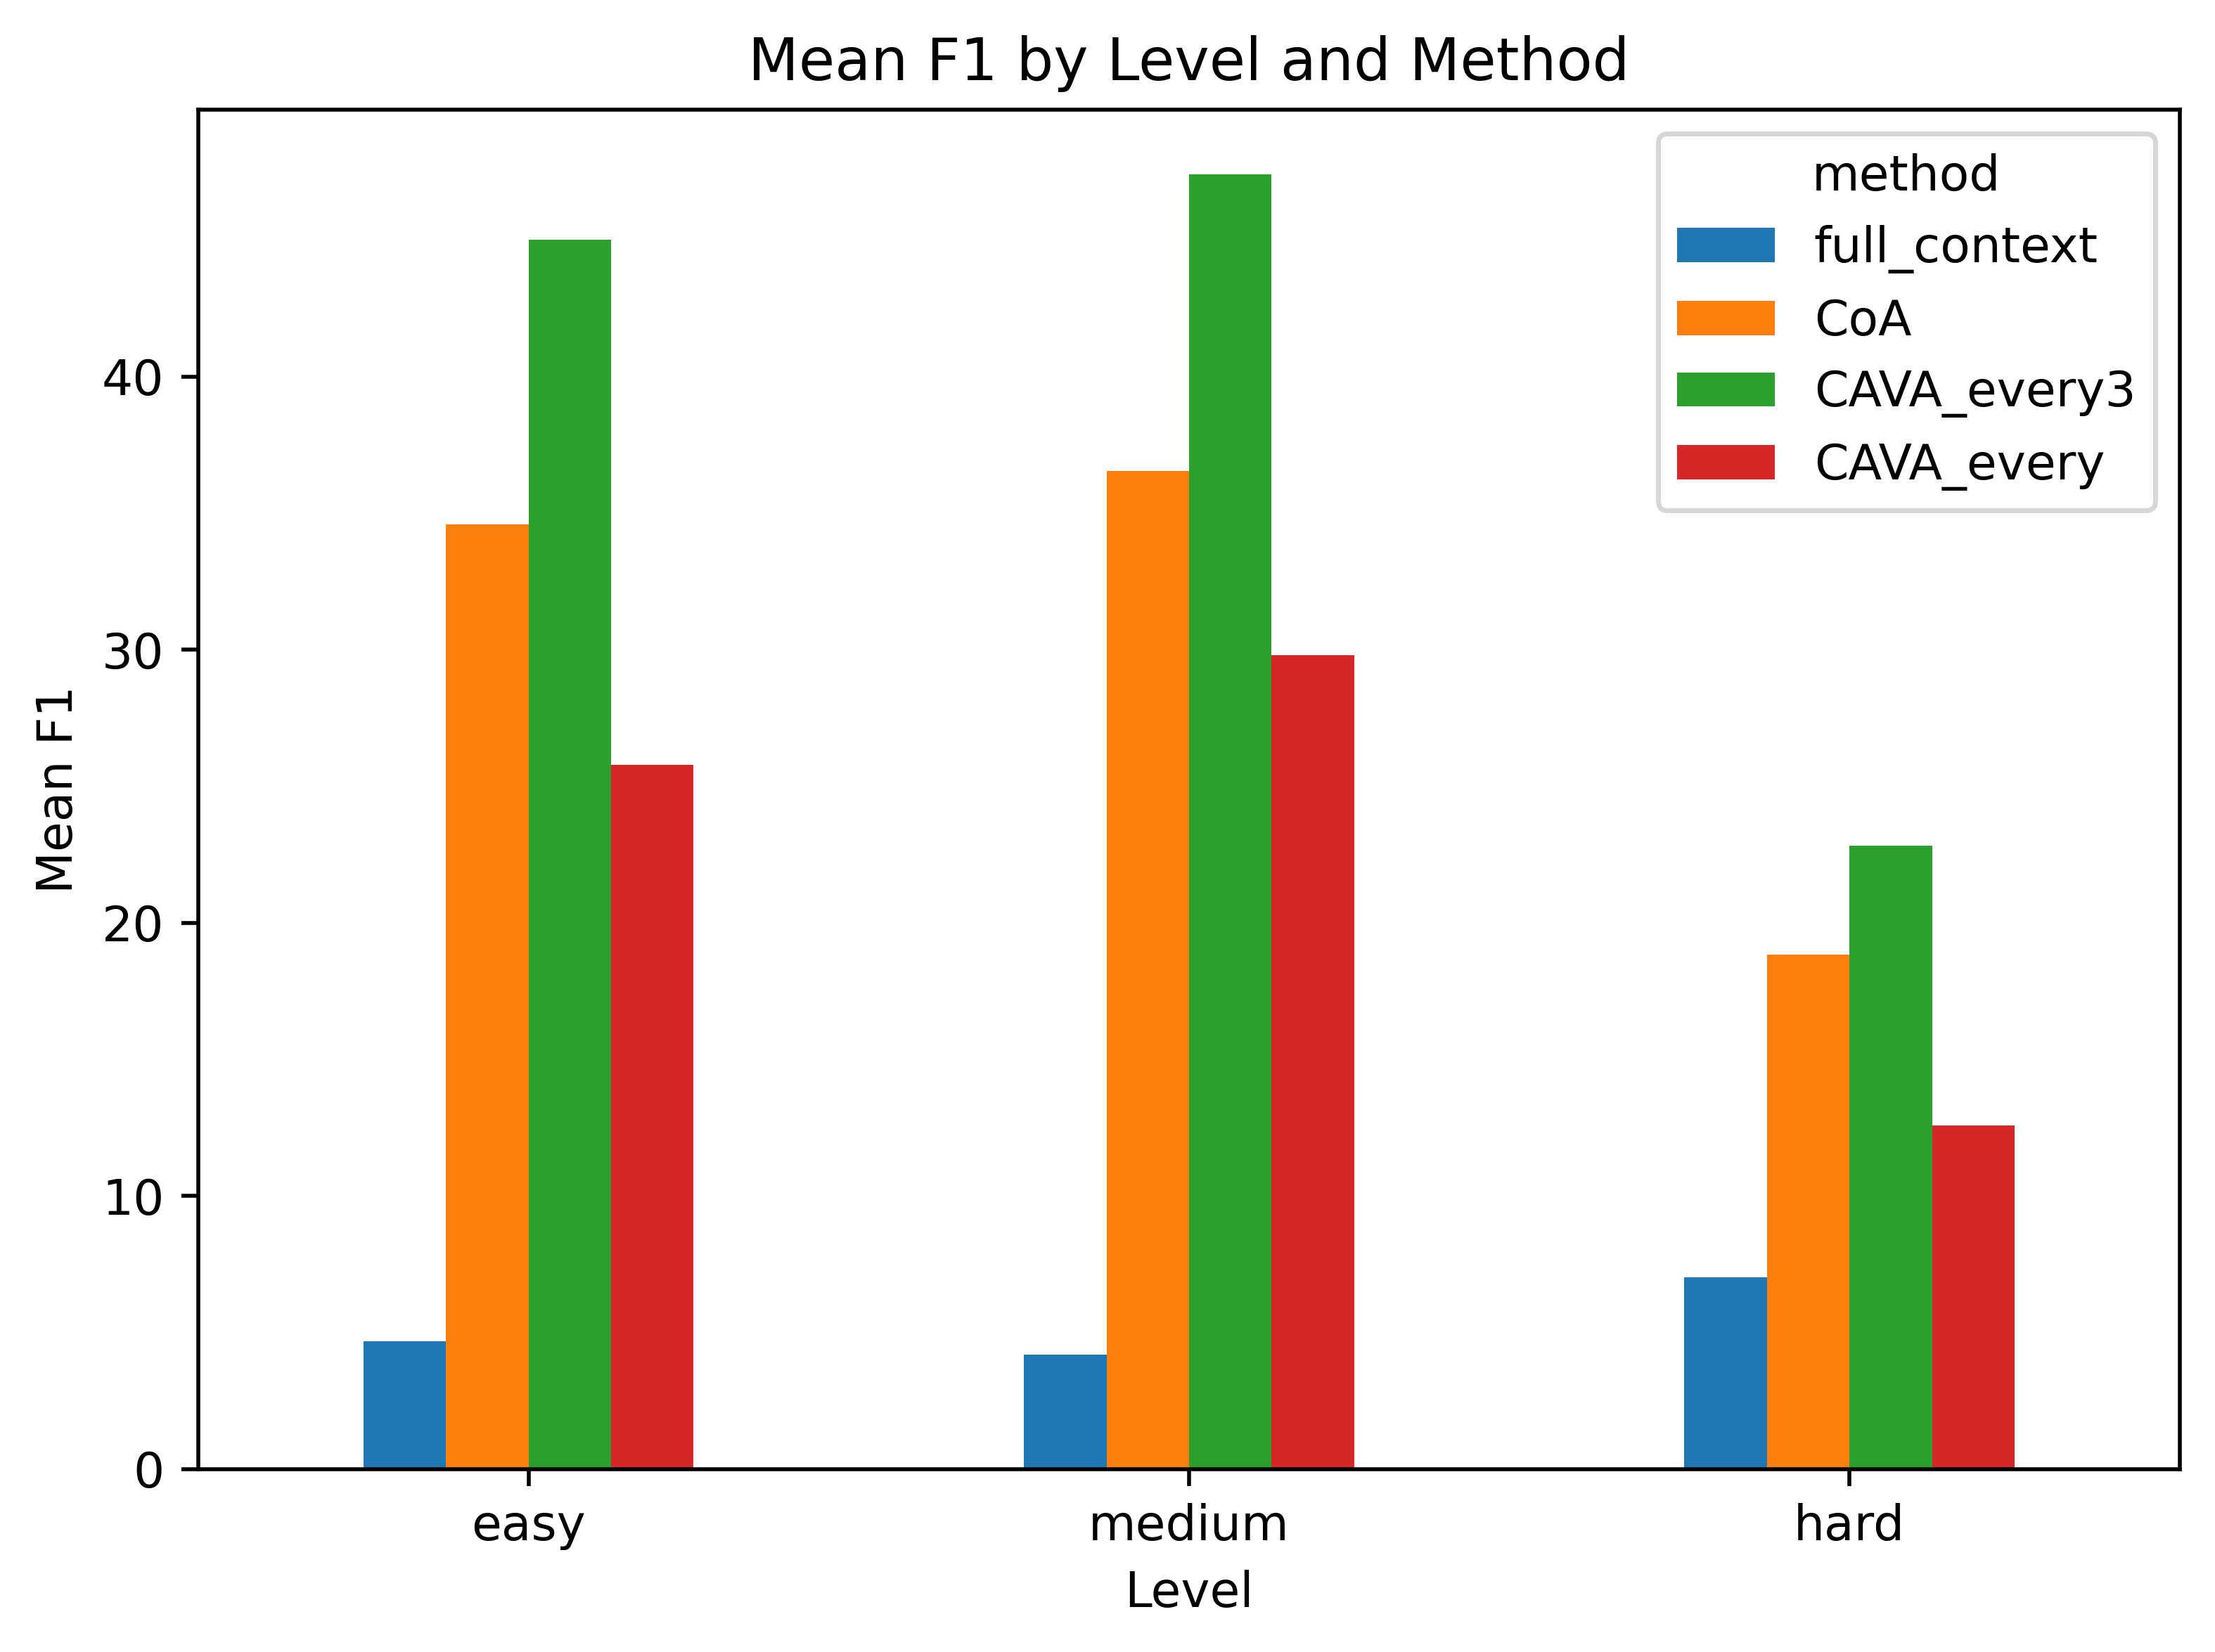

In [55]:
def plot_by_(type_summary: pd.DataFrame, by: str, metric: str = "mean_f1"):
    method_order = [
        "full_context",
        "CoA",
        "CAVA_every3",
        "CAVA_every",
    ]

    # Copy df to avoid modifying caller df
    df = type_summary.copy()

    # Enforce ordering for "level"
    if by == "level":
        level_order = ["easy", "medium", "hard"]
        df[by] = pd.Categorical(df[by], categories=level_order, ordered=True)

    # pivot table: rows = by (type/level), cols = methods
    pivot = df.pivot(index=by, columns="method", values=metric)

    # reorder method columns
    pivot = pivot.reindex(columns=method_order)

    # bar plot
    pivot.plot(kind="bar")
    plt.xlabel(f"{by.capitalize()}")
    plt.ylabel(f"Mean F1")
    plt.title(f"Mean F1 by {by.capitalize()} and Method")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# ---- Usage ----
plot_by_(summary_type, by="type", metric="mean_f1")
plot_by_(summary_level, by="level", metric="mean_f1")


<Figure size 3200x2400 with 0 Axes>

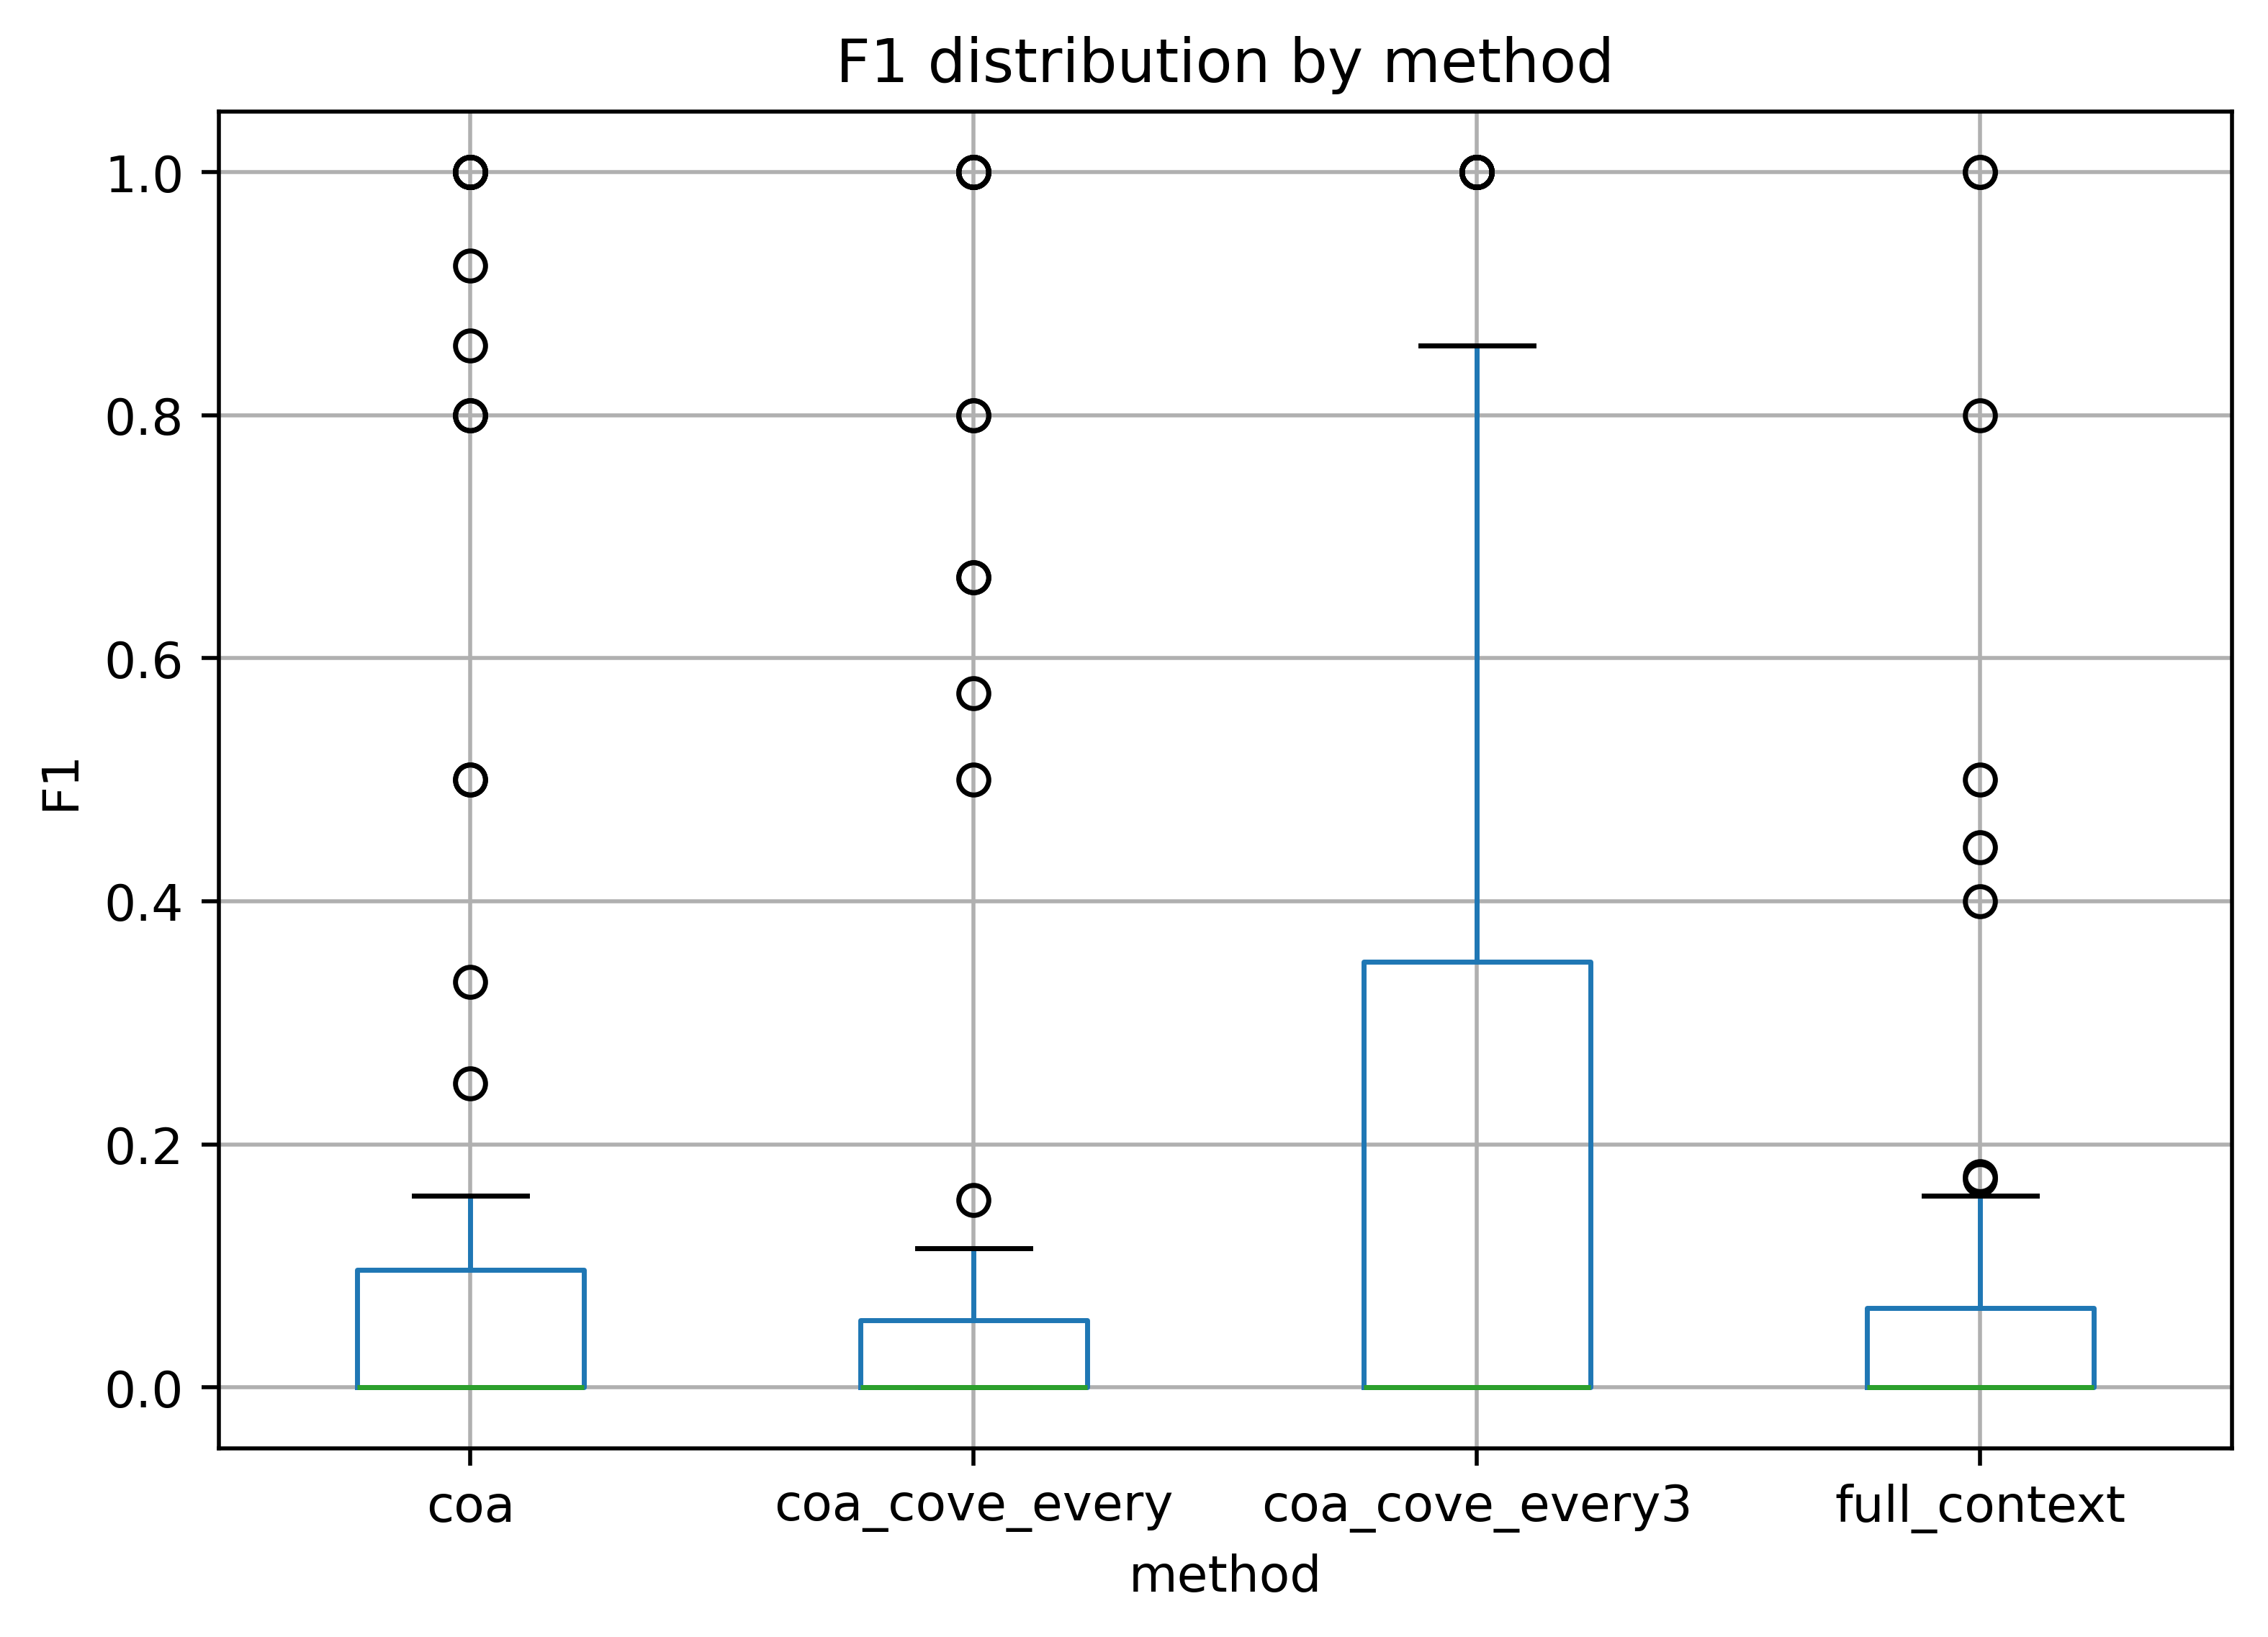

In [ ]:
def plot_f1_distribution(df: pd.DataFrame):
    plt.figure()
    df.boxplot(column="f1", by="method")
    plt.title("F1 distribution by method")
    plt.suptitle("")
    plt.ylabel("F1")
    plt.tight_layout()
    plt.show()

plot_f1_distribution(all_df)


## Qualitative

In [58]:
wide["delta_f1_CAVA_every3_vs_CoA"] = wide["f1_CAVA_every3"] - wide["f1_CoA"]
wide["delta_f1_CAVA_every3_vs_full"] = wide["f1_CAVA_every3"] - wide["f1_full_context"]

improve = wide.sort_values("delta_f1_CAVA_every3_vs_CoA", ascending=False)
improve.head(10)
# print(improved.head(5)[["question", "gold_answer", "f1_coa", "f1_coa_cove_every3"]])

,id,idx,type,level,question,gold_answer,em_CAVA_every,em_CAVA_every3,em_CoA,em_full_context,f1_CAVA_every,f1_CAVA_every3,f1_CoA,f1_full_context,delta_f1_CAVA_every3_vs_CoA,delta_f1_CAVA_every3_vs_full
61,5a8670c05542994775f6075f,38,bridge,medium,USS Anacapa was what type of heavily-armed mer...,Q-ship,1.0,1.0,0.0,0.0,1.000000,1.0,0.0,0.029412,1.0,0.970588
26,5a77e8f855429949eeb29fa1,47,bridge,medium,What Bostonian was the founder of the company ...,Douglas Gene Carlston,1.0,1.0,0.0,0.0,1.000000,1.0,0.0,0.077922,1.0,0.922078
183,5ae44d175542995dadf24306,9,bridge,medium,What Russian composer was notably conducted by...,Pyotr Ilyich Tchaikovsky,0.0,1.0,0.0,0.0,0.076923,1.0,0.0,0.000000,1.0,1.000000
112,5ab8664a55429919ba4e22db,69,bridge,easy,No Fixed Address is the eighth studio album by...,Nickelback,0.0,1.0,0.0,0.0,0.023256,1.0,0.0,0.032258,1.0,0.967742
116,5aba330c554299232ef4a270,51,bridge,easy,68 Silver Street was the home of the doctor of...,10 February 1775,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.000000,1.0,1.000000
96,5ab3b47e554299753aec59bd,29,comparison,medium,Are the Sadleria and Pleiospilos genuses nativ...,no,1.0,1.0,0.0,0.0,1.000000,1.0,0.0,0.024096,1.0,0.975904
92,5ab29c24554299449642c932,17,comparison,hard,Are Giuseppe Verdi and Ambroise Thomas both Op...,yes,0.0,1.0,0.0,0.0,0.105263,1.0,0.0,0.100000,1.0,0.900000
72,5a8a87ae5542996c9b8d5f20,0,comparison,easy,"Bozhou and Xuanwei, is in which country?",China,0.0,1.0,0.0,0.0,0.022222,1.0,0.0,0.030303,1.0,0.969697
141,5ac23ff0554299636651994d,30,bridge,hard,"When was Poison's album ""Shut Up, Make Love"" r...",2000,0.0,1.0,0.0,0.0,0.028571,1.0,0.0,0.028986,1.0,0.971014
167,5ae0fcac5542997b2ef7d0d0,83,bridge,medium,Brett C. Leonard wrote and produced for what c...,Hung,1.0,1.0,0.0,0.0,1.000000,1.0,0.0,0.025000,1.0,0.975000


In [59]:
decline = wide.sort_values("delta_f1_CAVA_every3_vs_CoA", ascending=True)
decline.head(10)

,id,idx,type,level,question,gold_answer,em_CAVA_every,em_CAVA_every3,em_CoA,em_full_context,f1_CAVA_every,f1_CAVA_every3,f1_CoA,f1_full_context,delta_f1_CAVA_every3_vs_CoA,delta_f1_CAVA_every3_vs_full
11,5a745c7c55429929fddd83fb,54,bridge,medium,What Hugh Wilson directed film did Neal Israel...,Police Academy,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.041667,-1.000000,-0.041667
27,5a78bd9b554299078472774a,78,bridge,hard,What nationality were social anthropologists A...,British,1.0,0.0,1.0,0.0,1.000000,0.000000,1.000000,0.026316,-1.000000,-0.026316
95,5ab3b0bf5542992ade7c6e39,12,bridge,hard,What year did Guns N Roses perform a promo for...,1999,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.023529,-1.000000,-0.023529
75,5a8b57f25542995d1e6f1371,0,comparison,hard,Were Scott Derrickson and Ed Wood of the same ...,yes,0.0,0.0,1.0,0.0,0.076923,0.000000,1.000000,0.000000,-1.000000,0.000000
194,5ae77fe35542997ec272766e,64,bridge,medium,The video game Ziggurat is largely inspired b...,Raven Software,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.049383,-1.000000,-0.049383
132,5abf2dda5542993fe9a41de3,12,bridge,medium,Michael Rao is an American academic administra...,"$12,540,000",0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000
12,5a74ada55542996c70cfada8,59,bridge,medium,Timothy Dalton acted in which 2007 comedy film...,Hot Fuzz,0.0,0.0,1.0,0.0,0.363636,0.055556,1.000000,0.045977,-0.944444,0.009579
125,5abcd7f25542993a06baf981,55,bridge,medium,"In 2016, what was the estimated sale of one of...",$2.65 billion,0.0,0.0,1.0,0.0,0.000000,0.058824,1.000000,0.053333,-0.941176,0.005490
33,5a7be2595542997c3ec972ac,62,comparison,hard,"Who was born earlier, Emma Bull or Virginia Wo...",Adeline Virginia Woolf,0.0,0.0,0.0,0.0,0.000000,0.000000,0.800000,0.000000,-0.800000,0.000000
113,5ab96ab755429970cfb8eacd,54,bridge,hard,Ellie Goulding worked with what other writers ...,"Max Martin, Savan Kotecha and Ilya Salmanzadeh",0.0,0.0,0.0,0.0,0.000000,0.157303,0.923077,0.153846,-0.765774,0.003457
